In [1]:
# Torch and torchvision are already pre-installed in Kaggle


In [2]:
!git clone https://github.com/xuebinqin/U-2-Net.git

Cloning into 'U-2-Net'...
remote: Enumerating objects: 1077, done.
remote: Counting objects: 100% (423/423), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 1077 (delta 398), reused 381 (delta 380), pack-reused 654 (from 1)
Receiving objects: 100% (1077/1077), 66.95 MiB | 40.35 MiB/s, done.
Resolving deltas: 100% (536/536), done.


In [3]:
%cd U-2-Net

/kaggle/working/U-2-Net


In [4]:
import os

import shutil

from sklearn.model_selection import train_test_split



# Define your image and mask directories

image_dir = '/kaggle/input/brain-tumor-segmentation/images'  # or wherever the images are stored

mask_dir = '/kaggle/input/brain-tumor-segmentation/masks'    # or wherever the masks are stored



# List all image files

images = sorted(os.listdir(image_dir))

masks = sorted(os.listdir(mask_dir))



# Check that the number of images and masks match

assert len(images) == len(masks), "Mismatch between image and mask files!"

In [5]:
# First, split into train (80%) and temp (20%)

train_images, temp_images, train_masks, temp_masks = train_test_split(

    images, masks, test_size=0.2, random_state=42)



# Then split temp into validation (50% of temp, which is 10% of total) and test (remaining 10%)

val_images, test_images, val_masks, test_masks = train_test_split(

    temp_images, temp_masks, test_size=0.5, random_state=42)



# Create directories for train, validation, and test sets

os.makedirs('/kaggle/working/bts/train/images', exist_ok=True)

os.makedirs('/kaggle/working/bts/train/masks', exist_ok=True)

os.makedirs('/kaggle/working/bts/val/images', exist_ok=True)

os.makedirs('/kaggle/working/bts/val/masks', exist_ok=True)

os.makedirs('/kaggle/working/bts/test/images', exist_ok=True)

os.makedirs('/kaggle/working/bts/test/masks', exist_ok=True)



# Move the files to their respective directories

for img, mask in zip(train_images, train_masks):

    shutil.copy(os.path.join(image_dir, img), '/kaggle/working/bts/train/images/')

    shutil.copy(os.path.join(mask_dir, mask), '/kaggle/working/bts/train/masks/')



for img, mask in zip(val_images, val_masks):

    shutil.copy(os.path.join(image_dir, img), '/kaggle/working/bts/val/images/')

    shutil.copy(os.path.join(mask_dir, mask), '/kaggle/working/bts/val/masks/')



for img, mask in zip(test_images, test_masks):

    shutil.copy(os.path.join(image_dir, img), '/kaggle/working/bts/test/images/')

    shutil.copy(os.path.join(mask_dir, mask), '/kaggle/working/bts/test/masks/')


In [6]:
from PIL import Image
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms

# Define a custom dataset class
class TumorSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg", ".png"))  # Adjust as needed

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Load mask in grayscale

        # Apply image transform
        if self.image_transform:
            image = self.image_transform(image)

        # Apply mask transform
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

# Define transformations for images and masks separately
image_transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),  # Masks should be converted to tensor, but typically no normalization
])

# Load the datasets using separate transforms
train_dataset = TumorSegmentationDataset(
    '/kaggle/working/bts/train/images',
    '/kaggle/working/bts/train/masks',
    image_transform=image_transform,
    mask_transform=mask_transform
)

val_dataset = TumorSegmentationDataset(
    '/kaggle/working/bts/val/images',
    '/kaggle/working/bts/val/masks',
    image_transform=image_transform,
    mask_transform=mask_transform
)

test_dataset = TumorSegmentationDataset(
    '/kaggle/working/bts/test/images',
    '/kaggle/working/bts/test/masks',
    image_transform=image_transform,
    mask_transform=mask_transform
)

# Create DataLoader objects
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)


In [7]:
from model import U2NET  # Import the U^2-Net model



# Initialize the U^2-Net model

model = U2NET(3, 1)  # 3 input channels (RGB) and 1 output channel (binary segmentation)



# Move the model to the GPU for faster training if available

model = model.cuda()


In [8]:
pip install torchsummary


Note: you may need to restart the kernel to use updated packages.


In [9]:
from torchsummary import summary
summary(model, input_size=(3, 320, 320))  # Input size: channels, height, width

/kaggle/working/U-2-Net/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]           1,792
       BatchNorm2d-2         [-1, 64, 320, 320]             128
              ReLU-3         [-1, 64, 320, 320]               0
          REBNCONV-4         [-1, 64, 320, 320]               0
            Conv2d-5         [-1, 32, 320, 320]          18,464
       BatchNorm2d-6         [-1, 32, 320, 320]              64
              ReLU-7         [-1, 32, 320, 320]               0
          REBNCONV-8         [-1, 32, 320, 320]               0
         MaxPool2d-9         [-1, 32, 160, 160]               0
           Conv2d-10         [-1, 32, 160, 160]           9,248
      BatchNorm2d-11         [-1, 32, 160, 160]              64
             ReLU-12         [-1, 32, 160, 160]               0
         REBNCONV-13         [-1, 32, 160, 160]               0
        MaxPool2d-14           [-1, 32,

In [10]:
import torch.optim as optim

import torch.nn as nn



# Define loss function (Binary Cross Entropy)

criterion = nn.BCELoss()



# Define the optimizer (Adam optimizer is generally effective for segmentation tasks)

optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm  # Import tqdm for progress bars

# Check for available GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming 'model' is already defined, let's wrap it in DataParallel if more than one GPU is available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model.to(device)  # Move model to the appropriate device

# Function to calculate accuracy
def calculate_accuracy(preds, labels):
    preds = (preds > 0.5).float()  # Apply threshold to get binary predictions
    correct = (preds == labels).float().sum()  # Count correct pixels
    total = torch.numel(preds)  # Total number of pixels
    accuracy = correct / total
    return accuracy

# Training loop with validation loss and accuracy
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Training phase with progress bar
        for images, masks in tqdm(train_loader, desc=f'Training Epoch {epoch + 1}/{num_epochs}', leave=False):
            images = images.to(device)  # Move images to GPU
            masks = masks.to(device)    # Move masks to GPU

            # Forward pass
            optimizer.zero_grad()  # Clear gradients
            outputs = model(images)
            loss = criterion(outputs[0], masks)  # U-Net has multiple outputs, use the main one

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_accuracy = 0.0

        # Validation phase with progress bar
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f'Validating Epoch {epoch + 1}/{num_epochs}', leave=False):
                images = images.to(device)  # Move images to GPU
                masks = masks.to(device)    # Move masks to GPU

                outputs = model(images)
                loss = criterion(outputs[0], masks)  # Validation loss
                val_loss += loss.item()

                # Calculate validation accuracy
                accuracy = calculate_accuracy(outputs[0], masks)
                val_accuracy += accuracy.item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)

        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}")

# Assuming the dataset class is defined as TumorSegmentationDataset
# Load your datasets with num_workers set to 2
train_dataset = TumorSegmentationDataset('/kaggle/working/bts/train/images', '/kaggle/working/bts/train/masks', image_transform=image_transform, mask_transform=mask_transform)
val_dataset = TumorSegmentationDataset('/kaggle/working/bts/val/images', '/kaggle/working/bts/val/masks', image_transform=image_transform, mask_transform=mask_transform)
test_dataset = TumorSegmentationDataset('/kaggle/working/bts/test/images', '/kaggle/working/bts/test/masks', image_transform=image_transform, mask_transform=mask_transform)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)


Using device: cuda
Using 2 GPUs!


Training Epoch 1/50:   0%|          | 0/307 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch [1/50], Loss: 0.0463


Validation Loss: 0.0347, Validation Accuracy: 0.9865


Epoch [2/50], Loss: 0.0336


Validation Loss: 0.0404, Validation Accuracy: 0.9840


Epoch [3/50], Loss: 0.0287


Validation Loss: 0.0292, Validation Accuracy: 0.9889


Epoch [4/50], Loss: 0.0241


Validation Loss: 0.0216, Validation Accuracy: 0.9907


Epoch [5/50], Loss: 0.0219


Validation Loss: 0.0205, Validation Accuracy: 0.9910


Epoch [6/50], Loss: 0.0229


Validation Loss: 0.0201, Validation Accuracy: 0.9915


Epoch [7/50], Loss: 0.0204


Validation Loss: 0.0169, Validation Accuracy: 0.9922


Epoch [8/50], Loss: 0.0187


Validation Loss: 0.0239, Validation Accuracy: 0.9902


Epoch [9/50], Loss: 0.0172


Validation Loss: 0.0171, Validation Accuracy: 0.9922


Epoch [10/50], Loss: 0.0168


Validation Loss: 0.0163, Validation Accuracy: 0.9926


Epoch [11/50], Loss: 0.0156


Validation Loss: 0.0164, Validation Accuracy: 0.9923


Epoch [12/50], Loss: 0.0153


Validation Loss: 0.0212, Validation Accuracy: 0.9911


Epoch [13/50], Loss: 0.0153


Validation Loss: 0.0158, Validation Accuracy: 0.9924


Epoch [14/50], Loss: 0.0131


Validation Loss: 0.0154, Validation Accuracy: 0.9927


Epoch [15/50], Loss: 0.0120


Validation Loss: 0.0153, Validation Accuracy: 0.9929


Epoch [16/50], Loss: 0.0126


Validation Loss: 0.0159, Validation Accuracy: 0.9928


Epoch [17/50], Loss: 0.0112


Validation Loss: 0.0154, Validation Accuracy: 0.9930


Epoch [18/50], Loss: 0.0125


Validation Loss: 0.0170, Validation Accuracy: 0.9923


Epoch [19/50], Loss: 0.0116


Validation Loss: 0.0184, Validation Accuracy: 0.9923


Epoch [20/50], Loss: 0.0106


Validation Loss: 0.0153, Validation Accuracy: 0.9928


Epoch [21/50], Loss: 0.0094


Validation Loss: 0.0145, Validation Accuracy: 0.9934


Epoch [22/50], Loss: 0.0111


Validation Loss: 0.0157, Validation Accuracy: 0.9928


Epoch [23/50], Loss: 0.0092


Validation Loss: 0.0150, Validation Accuracy: 0.9934


Epoch [24/50], Loss: 0.0088


Validation Loss: 0.0153, Validation Accuracy: 0.9935


Epoch [25/50], Loss: 0.0082


Validation Loss: 0.0141, Validation Accuracy: 0.9936


Epoch [26/50], Loss: 0.0076


Validation Loss: 0.0182, Validation Accuracy: 0.9929


Epoch [27/50], Loss: 0.0076


Validation Loss: 0.0160, Validation Accuracy: 0.9935


Epoch [28/50], Loss: 0.0074


Validation Loss: 0.0156, Validation Accuracy: 0.9936


Epoch [29/50], Loss: 0.0075


Validation Loss: 0.0151, Validation Accuracy: 0.9932


Epoch [30/50], Loss: 0.0066


Validation Loss: 0.0143, Validation Accuracy: 0.9939


Epoch [31/50], Loss: 0.0066


Validation Loss: 0.0157, Validation Accuracy: 0.9935


Epoch [32/50], Loss: 0.0070


Validation Loss: 0.0149, Validation Accuracy: 0.9936


Epoch [33/50], Loss: 0.0064


Validation Loss: 0.0150, Validation Accuracy: 0.9937


Epoch [34/50], Loss: 0.0061


Validation Loss: 0.0154, Validation Accuracy: 0.9935


Epoch [35/50], Loss: 0.0060


Validation Loss: 0.0146, Validation Accuracy: 0.9937


Epoch [36/50], Loss: 0.0062


Validation Loss: 0.0164, Validation Accuracy: 0.9937


Epoch [37/50], Loss: 0.0051


Validation Loss: 0.0169, Validation Accuracy: 0.9939


Epoch [38/50], Loss: 0.0049


Validation Loss: 0.0169, Validation Accuracy: 0.9934


Epoch [39/50], Loss: 0.0048


Validation Loss: 0.0166, Validation Accuracy: 0.9938


Epoch [40/50], Loss: 0.0044


Validation Loss: 0.0156, Validation Accuracy: 0.9939


Epoch [41/50], Loss: 0.0045


Validation Loss: 0.0190, Validation Accuracy: 0.9937


Epoch [42/50], Loss: 0.0060


Validation Loss: 0.0159, Validation Accuracy: 0.9933


Epoch [43/50], Loss: 0.0048


Validation Loss: 0.0167, Validation Accuracy: 0.9939


Epoch [44/50], Loss: 0.0040


Validation Loss: 0.0168, Validation Accuracy: 0.9939


Epoch [45/50], Loss: 0.0052


Validation Loss: 0.0179, Validation Accuracy: 0.9936


Epoch [46/50], Loss: 0.0043


Validation Loss: 0.0172, Validation Accuracy: 0.9938


Epoch [47/50], Loss: 0.0037


Validation Loss: 0.0192, Validation Accuracy: 0.9938


Epoch [48/50], Loss: 0.0034


Validation Loss: 0.0184, Validation Accuracy: 0.9941


Epoch [49/50], Loss: 0.0035


Validation Loss: 0.0194, Validation Accuracy: 0.9939


Epoch [50/50], Loss: 0.0041


Validation Loss: 0.0173, Validation Accuracy: 0.9939


Accuracy: 0.9966


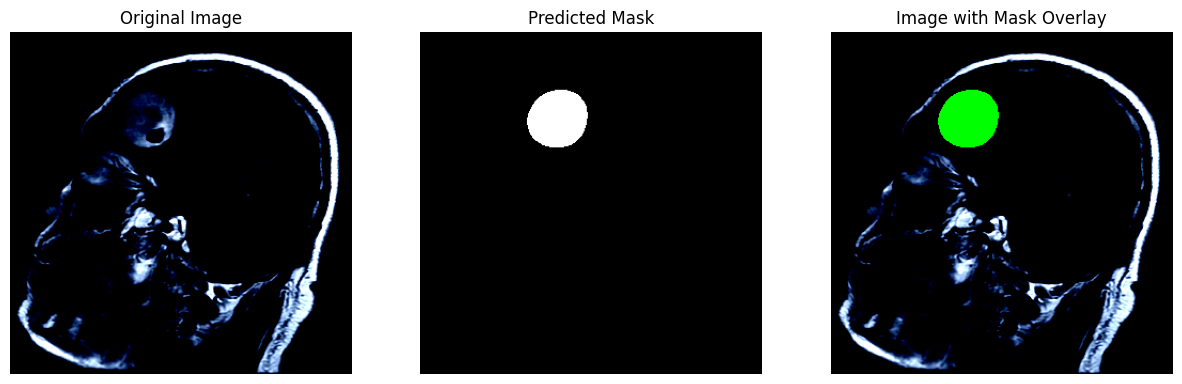

In [12]:
import random

import torch

import matplotlib.pyplot as plt

import numpy as np

from torchvision.transforms import ToPILImage

import cv2  # To overlay the mask on the original image



# Helper function to display images

def show_image_mask_overlay(image, mask):

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))



    # Convert tensor image to numpy (transpose to change from CxHxW to HxWxC)

    img_np = image.cpu().numpy().transpose(1, 2, 0)

    mask_np = mask.cpu().numpy().squeeze()  # Remove extra dimensions



    # Display original image

    axs[0].imshow(img_np)

    axs[0].set_title("Original Image")

    axs[0].axis('off')



    # Display predicted mask

    axs[1].imshow(mask_np, cmap='gray')

    axs[1].set_title("Predicted Mask")

    axs[1].axis('off')



    # Overlay mask on image (use OpenCV to overlay mask with color)

    overlay = img_np.copy()

    overlay[mask_np > 0.5] = [0, 1, 0]  # Set tumor region to red



    axs[2].imshow(overlay)

    axs[2].set_title("Image with Mask Overlay")

    axs[2].axis('off')



    plt.show()



# Function to calculate accuracy

def calculate_accuracy(preds, labels):

    preds = (preds > 0.5).float()  # Threshold to get binary predictions (0 or 1)



    # Flatten the arrays to compare each pixel

    preds_flat = preds.cpu().numpy().flatten()

    labels_flat = labels.cpu().numpy().flatten()



    accuracy = np.mean(preds_flat == labels_flat)  # Calculate pixel-wise accuracy

    return accuracy



# Function to test on a random image from test set

def test_random_image(model, test_loader):

    model.eval()  # Set model to evaluation mode



    # Select a random batch from the test loader

    random_batch = random.randint(0, len(test_loader) - 1)



    for i, (images, masks) in enumerate(test_loader):

        if i == random_batch:

            random_index = random.randint(0, images.size(0) - 1)  # Select random image from batch



            image = images[random_index].unsqueeze(0).cuda()  # Add batch dimension and move to GPU

            mask = masks[random_index].unsqueeze(0).cuda()    # Ground truth mask for comparison



            # Get the model's prediction

            with torch.no_grad():

                output = model(image)

                predicted_mask = output[0]  # Take the main output

                predicted_mask = (predicted_mask > 0.5).float()  # Threshold for binary mask



            # Calculate accuracy for the selected image

            accuracy = calculate_accuracy(predicted_mask, mask)

            print(f"Accuracy: {accuracy:.4f}")



            # Remove the batch dimension for visualization

            image = image.squeeze(0)

            predicted_mask = predicted_mask.squeeze(0)



            # Display the original image, predicted mask, and image with overlay

            show_image_mask_overlay(image, predicted_mask)

            break



# Call the function to test and display on a random image

test_random_image(model, test_loader)

In [13]:
import torch

import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



# Function to calculate metrics

def calculate_metrics(preds, labels):

    # Ensure predictions are binary (0 or 1)

    preds_binary = (preds > 0.5).float()  # Convert to binary predictions



    # Flatten the arrays to calculate metrics for the entire image

    preds_flat = preds_binary.cpu().numpy().flatten()

    labels_flat = labels.cpu().numpy().flatten()



    # Convert labels to integers (0 or 1) if they are not already

    labels_flat = labels_flat.astype(int)



    # Calculate metrics

    accuracy = accuracy_score(labels_flat, preds_flat)

    precision = precision_score(labels_flat, preds_flat)

    recall = recall_score(labels_flat, preds_flat)

    f1 = f1_score(labels_flat, preds_flat)



    return accuracy, precision, recall, f1



# Function to evaluate the model on the entire test set

def evaluate_model(model, test_loader):

    model.eval()  # Set model to evaluation mode

    total_accuracy = 0

    total_precision = 0

    total_recall = 0

    total_f1 = 0

    total_images = 0



    with torch.no_grad():  # No need to calculate gradients

        for images, masks in test_loader:

            images = images.cuda()

            masks = masks.cuda()



            # Forward pass to get model's predictions

            outputs = model(images)

            preds = outputs[0]  # Use the main output of U^2-Net



            # Calculate metrics for this batch

            accuracy, precision, recall, f1 = calculate_metrics(preds, masks)

            total_accuracy += accuracy * images.size(0)  # Weight by batch size

            total_precision += precision * images.size(0)

            total_recall += recall * images.size(0)

            total_f1 += f1 * images.size(0)

            total_images += images.size(0)  # Update total images count



    # Average metrics across all test batches

    avg_accuracy = total_accuracy / total_images

    avg_precision = total_precision / total_images

    avg_recall = total_recall / total_images

    avg_f1 = total_f1 / total_images



    print(f"Test Accuracy: {avg_accuracy:.4f}")

    print(f"Test Precision: {avg_precision:.4f}")

    print(f"Test Recall: {avg_recall:.4f}")

    print(f"Test F1 Score: {avg_f1:.4f}")



# Call the function to evaluate the model on the test set

evaluate_model(model, test_loader)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/kaggle/working/U-2-Net/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/kaggle/working/U-2-Net/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
/opt/con

Test Accuracy: 0.9947
Test Precision: 0.8366
Test Recall: 0.8447
Test F1 Score: 0.8385


In [14]:
# Function to calculate IoU

def calculate_iou(preds, labels):

    # Ensure predictions are binary (0 or 1)

    preds_binary = (preds > 0.5).float()  # Convert to binary predictions



    # Flatten the arrays to calculate IoU for the entire image

    preds_flat = preds_binary.cpu().numpy().flatten()

    labels_flat = labels.cpu().numpy().flatten()



    # Convert labels to integers (0 or 1) if they are not already

    labels_flat = labels_flat.astype(int)



    # Calculate intersection and union

    intersection = np.logical_and(preds_flat, labels_flat).sum()

    union = np.logical_or(preds_flat, labels_flat).sum()



    # Calculate IoU (handle division by zero)

    iou = intersection / union if union != 0 else 0.0



    return iou



# Calculate and print IoU for the test set

def evaluate_iou(model, test_loader):

    model.eval()  # Set model to evaluation mode

    total_iou = 0

    total_images = 0



    with torch.no_grad():

        for images, masks in test_loader:

            images = images.cuda()

            masks = masks.cuda()



            outputs = model(images)

            preds = outputs[0]



            iou = calculate_iou(preds, masks)

            total_iou += iou * images.size(0)  # Weight by batch size

            total_images += images.size(0)



    # Average IoU across all test batches

    avg_iou = total_iou / total_images

    print(f"Test IoU: {avg_iou:.4f}")



# Call the function to evaluate IoU on the test set

evaluate_iou(model, test_loader)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/kaggle/working/U-2-Net/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


Test IoU: 0.7262
